# Looking for Malicious Users Through Apache Log Analysis

### Introduction
The inspiration for this project was to determine if/how malicous users could be identified by using machine learning tools to analyze Apache Web Server Logs. 

For this exercise, I use the freely-available Apache log samples available from NASA for one of their web servers from 1995. I'll start by identifying the kinds of data in the log file then isolate the activity on the site by user and perform [n-gram](https://en.wikipedia.org/wiki/N-gram) analysis to categorize new users as being 'typical' or 'a-typical'. The presumption is that 'a-typical' users would need to be analyzed further to determine if they were malicious. 

### Data Dictionary
Using additional analysis not included in this notebook, I was able to come up with this data dictionary to describe the contents of the data file.

 | Column     | Description |
 |------------|:-----------:|
 | host       | The hostname or IP address making the request to the website |
 | logname    | not a populated field |
 | time       | integer version of unix timestamp |
 | method     | HTTP method for the call |
 | url        | path to the file being requested |
 | response   | HTTP response code for the call |
 | bytes      | Number of bytes returned for the request |
 | referer    | not a populated field |
 | useragent  | not a populated field |

---

### Prerequisites for this Python Notebook
 - python 3.x
 - python packages
   - pip3 install pandas
   - pip3 install scikit-learn
   - pip3 install matplotlib
   - pip3 install networkx
 - jupyter notebook --debug > log.file 2>&1
 
### Sample data used for analysis
- http://indeedeng.github.io/imhotep/files/nasa_19950801.tsv (saved in 'rawData/nasa_19950801.tsv')
- http://indeedeng.github.io/imhotep/files/nasa_19950630.22-19950728.12.tsv.gz
- http://indeedeng.github.io/imhotep/files/nasa_19950731.22-19950831.22.tsv.gz

### Import necessary libraries

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
import hashlib 
import networkx as nx


### Read data file

In [81]:
apache_log_path = 'rawData/nasa_19950801.tsv'
apache_log_data = pd.read_csv(apache_log_path, sep='\t', header=0)

### Extract navigation path for most active user
This was found earlier to be 'edams.ksc.nasa.gov'. We've hard-coded that value here.

In [89]:
visitor_address = apache_log_data.host
histogram_visitor_address = visitor_address.value_counts()
most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == 'edams.ksc.nasa.gov']
most_active_user_path = most_active_user_logs['url']

### Create directed graph of single user's path to visualize the data
The bi-graph shows all the pairs of a path, the current node and the next node. This is ideal for defining a directed graph. While we will be using n-grams of a larger 'n' for our analysis, these bi-grams are useful for vor visualization.

We have our own home-grown function to create n-grams that omits information on the start and end of a user's path, but it will serve our needs for now. The 'tuple' version is for graphing and the 'dataframe' version is to make it a bit easier to read in column form.

In [90]:
#should unwind this a bit to make the purpose more clear
#also, there should be padding added to the front/back to indicate beginning and ending of a path
def find_ngrams(input_list, n):
  return [list(x) for x in set(tuple(x) for x in list(zip(*[input_list[i:] for i in range(n)])))]

most_active_user_path_bi_gram_as_tuples = list(find_ngrams(single_user_path,2))
labels=["node1","node2"]
most_active_user_path_bi_gram_as_dataframe = pd.DataFrame.from_records(most_active_user_path_bi_gram_as_tuples, columns=labels)
print(most_active_user_path_bi_gram_as_dataframe)

                           node1                         node2
0                      /ksc.html                     /ksc.html
1     /images/NASA-logosmall.gif  /images/MOSAIC-logosmall.gif
2     /images/ksclogo-medium.gif  /images/MOSAIC-logosmall.gif
3     /images/ksclogo-medium.gif    /images/NASA-logosmall.gif
4    /images/WORLD-logosmall.gif                     /ksc.html
5                 /htbin/wais.pl                     /ksc.html
6                      /ksc.html    /images/NASA-logosmall.gif
7     /images/NASA-logosmall.gif    /images/ksclogo-medium.gif
8    /images/WORLD-logosmall.gif    /images/NASA-logosmall.gif
9   /images/MOSAIC-logosmall.gif     /images/USA-logosmall.gif
10                  /\\yahoo.com                     /ksc.html
11   /images/WORLD-logosmall.gif                /htbin/wais.pl
12                     /ksc.html    /images/ksclogo-medium.gif
13   /images/WORLD-logosmall.gif                  /\\yahoo.com
14     /images/USA-logosmall.gif   /images/WORLD-logosm

### Most Active User's Path Through the Site Converted to a Directed Graph
We take the bi-grams (in tuple form) and feed it into our graphing method. The labels muddle the graph a bit, but the structure seems pretty simple.

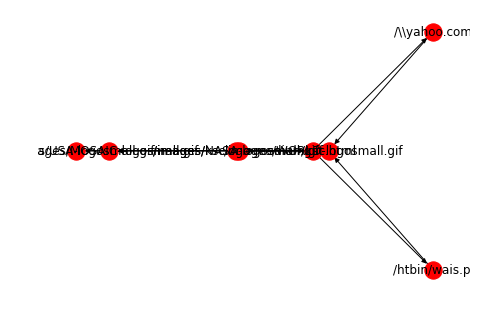

In [91]:
most_active_user_graph = nx.DiGraph()
most_active_user_graph.add_edges_from(most_active_user_path_bi_gram_as_tuples)
nx.draw_spectral(most_active_user_graph, arrows=True, with_labels=True)

### Now, let's look at the graph for the second most active user
We see from earlier analysis (not listed here) that it's the IP address '130.110.74.81'. This structure is certainly different, but it looks like there are some straightforward paths through the site that this user takes.

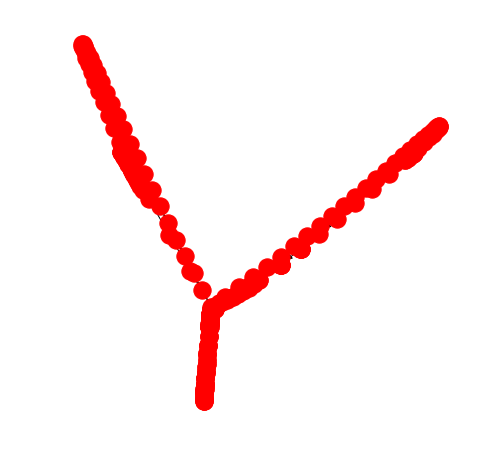

In [85]:
#get just the entries from the second most active user
second_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == '130.110.74.81']
#get a list of just the URLs for that user
second_most_active_user_path = second_most_active_user_logs['url']
#create bi-gram for graph
second_most_active_user_path_bi_gram = list(find_ngrams(second_most_active_user_path,2))
#generate graph 
second_most_active_user_graph = nx.DiGraph()
second_most_active_user_graph.add_edges_from(second_most_active_user_path_bi_gram)
plt.figure(3,figsize=(6,6)) 
nx.draw_spectral(second_most_active_user_graph, arrows=True, with_labels=False)  

### Let's look at the generic case. 
We can get the graph for a particular user by specifying the index of user from the histogram table (choose an index less than 2365 for this dataset). Note the various structures of each user as you re-run the code after changing the index. 

Note: Since the n-gram function doesn't consider the beginning and end of a users path through the system, the users that requested a single element from the server will not show any graph because there is not enough data. Additional, users with an index larger than about 1900 in this dataset will not show useful graphs because they are essentially very small. Once the n-gram function is corrected, each user would have a graph showing the start and end nodes and the single element the user requested.

pppa11.netwave.net


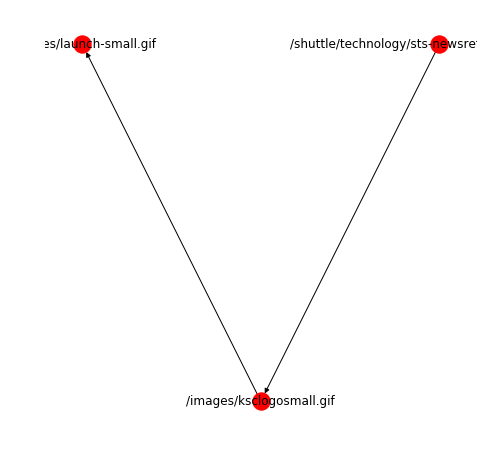

In [86]:
#Change this value from 1 to 2364 for this datasset
#Most interesting data is for values between 1 and 1900
index_to_graph = 1900

#Code to get data for this index
visitor_addresses = apache_log_data.host
histogram_visitor_address = visitor_addresses.value_counts()
visitor_address = histogram_visitor_address.index[index_to_graph]
print(visitor_address)

#get just the entries from the second most active user
nth_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == visitor_address]
#get a list of just the URLs for that user
nth_most_active_user_path = nth_most_active_user_logs['url']

#create bi-gram for graph
nth_most_active_user_path_bi_gram = list(find_ngrams(nth_most_active_user_path,2))
#generate graph
nth_most_active_user_graph = nx.DiGraph()
nth_most_active_user_graph.add_edges_from(nth_most_active_user_path_bi_gram)
plt.figure(3,figsize=(6,6)) 
nx.draw_spectral(nth_most_active_user_graph,  arrows=True, with_labels=True)


# Now What?
If we presume that the patterns we've seen so far hold for the general case, we could surmise that the pattern of a user is an arc of usage that follows long sequences of requests and occasionally re-visiting previously visited elements.

### The Next Experiment

Ultimately, we are interested in determining if a pattern of usage for a new visitor looks 'typical' or 'a-typical'. In this case, we have existing usage that we will presume to be 'typical'. 

In this experiment, we'll use the [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) also known as the 'edit distance' to compare a new path observed by a user to existing paths by other users. The Levenshtein Distance is called the 'edit distance' because it measures the number of edits it would take to change the first sequence to the second sequence. 

Rather than compare the full sequences of users' paths through the server to calculate the distance, we'll compare n-grams. It's not clear what choice of 'n' would be useful, so there will need to be some effort expended to choose a suitable 'n'.

We'll correspondingly have a point at which we determine where the minimum Levenshtein Distance classifies the new sequence as 'typical' or 'a-typical'.
